# Natural Language Processing with Disaster Tweets - Bidirectional LSTM Recurrent Neural Net

In this notebook, we will make predictions about the disaster tweets using a recurrent neural net with two Bidirectional LSTM layers.

We will be using Tensorflow's functional API.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# suppress warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding, Bidirectional, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras import backend as K

## Preliminaries

We rely on GloVe word embeddings. The specific data we use is [glove.twitter.27B](https://nlp.stanford.edu/projects/glove/). The following function reads the GloVe data.

In [2]:
def read_glove(glove_file):
    """
    glove_file - path to the glove file
    
    returns:
    words_to_index - dictionary matching word (string) to its index in the sorted glove dataset
    word_to_vec - like above, but returns the corresponding embedding vector
    """
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        for w in sorted(words): # sorting!
            words_to_index[w] = i
            i = i + 1
    return words_to_index, word_to_vec

In [3]:
# pick the dimension of word embeddings: 25, 50, 100, 200
emb_dim = 200
word_to_index, word_to_vec = read_glove(
    'data/glove.twitter.27B/glove.twitter.27B.'+str(emb_dim)+'d.txt'
)

Next, we read the previously cleaned location data as well as the tokenized tweets.

In [4]:
def read_locations(loc_file):
    """
    loc_file - path to the csv file containing locations
    returns vector of the shape (n_locations, 1) of strings which are the locations
    """
    locations = pd.read_csv(loc_file)
    locations = locations.fillna('Worldwide')
    
    return locations['location'].values.reshape((locations.shape[0],-1))

In [5]:
Xloc_train = read_locations('data/location_train.csv')
Xloc_test = read_locations('data/location_test.csv')
Xloc_alldata = np.concatenate([Xloc_train, Xloc_test])

One-hot encode the locations.

In [6]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Xloc_alldata)

Xloc_train_one_hot = enc.transform(Xloc_train).toarray()
Xloc_test_one_hot = enc.transform(Xloc_test).toarray()

loc_one_hot_length = Xloc_test_one_hot.shape[1]
print( "Number of unique locations:\t" + str(loc_one_hot_length) )

Number of unique locations:	154


Next, we read the tweet indices that we created in the notebook [tweets_preprocessing.ipynb](tweets_preprocessing.ipynb).

In [7]:
def read_tweet_indices(ind_file):
    """
    ind_file - path to the file containing indices separated by spaces (tweets in consecutive lines)
    
    returns:
    lines - list of lists of indices (as strings)
    maxLen - maximum length of a tweet
    """
    with open(ind_file, 'r') as f:
        lines=[]
        maxLen=0
        for line in f:
            lines.append( line.strip().split() )
            if len(lines[-1]) > maxLen: maxLen=len(lines[-1])
        return lines, maxLen

In [8]:
def construct_Xtxt(ind_file_train, ind_file_test):
    """
    ind_file_train - path to the train file containing indices of tweets
    ind_file_test - path to the test file containing indices of tweets
    
    returns:
    maxLen - maximum length of a tweet
    X_train, X_test - matrices of indices of words in tweets filled with zeros - dimensions (N_tweets, maxLen) 
    """
    lines_test, maxLen_test = read_tweet_indices(ind_file_test)
    lines_train, maxLen_train = read_tweet_indices(ind_file_train)
    
    maxLen = max(maxLen_test, maxLen_train)
    
    X_test=np.zeros((len(lines_test), maxLen), dtype=int)
    X_train=np.zeros((len(lines_train), maxLen), dtype=int)
    for i in range(len(lines_test)):
        for j in range(len(lines_test[i])):
            X_test[i,j] = int(lines_test[i][j])
    
    for i in range(len(lines_train)):
        for j in range(len(lines_train[i])):
            X_train[i,j] = int(lines_train[i][j])
    
    return X_train, X_test, maxLen

In [9]:
X_train, X_test, maxLen = construct_Xtxt('data/tweet_indices_train.txt', 'data/tweet_indices_test.txt')
print( "Maximum tweet length:\t" + str(maxLen) )

Maximum tweet length:	38


Finally, we read off the target vector.

In [10]:
Y_train = pd.read_csv('data/train.csv')['target']
Y_train = Y_train.to_numpy().reshape(Y_train.shape[0],-1).astype(float)

## The LSTM Recurrent Neural Net

First, we define the embedding layer which takes the index matrix as input and returns the embeddings - output shape `(N_tweets, maxLen, emb_dim)`.

In [11]:
def pretrained_embedding_layer(word_to_vec, word_to_index):
    """
    Creates Embedding() layer and loads in pre-trained GloVe vectors.
    
    Arguments:
    word_to_vec -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer 
    """
    
    vocab_size = len(word_to_index) + 1
    any_word = list(word_to_vec.keys())[0]
    emb_dim = word_to_vec[any_word].shape[0] # dimension of the GloVe word vectors
      
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_size, emb_dim))
    
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        word_vec = word_to_vec[word]
        if word_vec.shape[0] == emb_dim:
            emb_matrix[idx, :] = word_vec

    # Define embedding layer and make it non-trainable.
    embedding_layer = Embedding(vocab_size, emb_dim, trainable=False) 
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer


Next, we construct the RNN according to the schamtic picture below.
<img src="net.png" width="620" height="500">

In [12]:
def nlp_tweets(input_indices_shape, input_loc_shape, word_to_vec, word_to_index):
    """
    Function creating the NLP model graph.
    
    Arguments:
    input_shape -- shape of the input (max_len,)
    word_to_vec -- dictionary mapping every word in a vocabulary into its vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary

    Returns:
    model -- a model instance
    """
    
    # Define sentence_indices as input1 of the graph.
    sentence_indices = Input(shape=input_indices_shape, dtype=tf.int32)
    
    # Define Xloc_one_hot as input2 of the graph
    Xloc_one_hot = Input(shape=input_loc_shape, dtype=tf.float32)
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer, return sequences.
    X = Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.3))(embeddings)
    # Add dropout
    X = Dropout(rate=0.7)(X)
    # Propagate X trough another LSTM layer, return a single hidden state.
    X = Bidirectional(LSTM(units=128, return_sequences=False, recurrent_dropout=0.3))(X)
    # Add dropout
    X = Dropout(rate=0.7)(X) 
    # Concatenate X with Xloc_one_hot
    X = Concatenate()([X, Xloc_one_hot])
    # Propagate X through a Dense layer
    X = Dense(units=10, activation='ReLU')(X)
    # Add dropout
    X = Dropout(rate=0.2)(X)
    # Output
    X = Dense(units=1, activation='sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[sentence_indices, Xloc_one_hot], outputs=X, name='NLP_Twitter')
    
    
    return model

In [13]:
model = nlp_tweets((maxLen,), (loc_one_hot_length, ), word_to_vec, word_to_index)
model.summary()

Model: "NLP_Twitter"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 38)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 38, 200)              2387030   ['input_1[0][0]']             
                                                          00                                      
                                                                                                  
 bidirectional (Bidirection  (None, 38, 256)              336896    ['embedding[0][0]']           
 al)                                                                                              
                                                                                        

According to the competition info, the evaluation metric is F1 score. Below, we implement this metric.

In [14]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Next, we compile the model with F1 score metric.

In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1_m])

We split the train set into train and dev sets.

In [16]:
X_train = np.concatenate([X_train, Xloc_train_one_hot], axis=1)
X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, shuffle=True, stratify=Y_train)

# extract text and location parts
Xloc_train = np.copy( X_train[:, -loc_one_hot_length:] )
Xtxt_train = np.copy( X_train[:, :maxLen] )
Xloc_dev = np.copy( X_dev[:, -loc_one_hot_length:] )
Xtxt_dev = np.copy( X_dev[:, :maxLen] )

It's time to train the model! We will train it for 25 epochs which is a bit of an early stopping. It prevents overfitting. If you train the model for longer, you will see that the CV score will start to slowly drop after epoch 25.

In [17]:
history = model.fit(
    [Xtxt_train, Xloc_train], Y_train, validation_data = (
        [Xtxt_dev, Xloc_dev], Y_dev
    ) , epochs = 25, batch_size = 64, shuffle=True
)

Epoch 1/25
96/96 [==============================] - 29s 228ms/step - loss: 0.6525 - f1_m: 0.3354 - val_loss: 0.5811 - val_f1_m: 0.6729
Epoch 2/25
96/96 [==============================] - 21s 224ms/step - loss: 0.5395 - f1_m: 0.6957 - val_loss: 0.4542 - val_f1_m: 0.7594
Epoch 3/25
96/96 [==============================] - 22s 225ms/step - loss: 0.4720 - f1_m: 0.7460 - val_loss: 0.4323 - val_f1_m: 0.7683
Epoch 4/25
96/96 [==============================] - 22s 232ms/step - loss: 0.4500 - f1_m: 0.7596 - val_loss: 0.4271 - val_f1_m: 0.7677
Epoch 5/25
96/96 [==============================] - 21s 214ms/step - loss: 0.4396 - f1_m: 0.7611 - val_loss: 0.4246 - val_f1_m: 0.7754
Epoch 6/25
96/96 [==============================] - 21s 218ms/step - loss: 0.4266 - f1_m: 0.7754 - val_loss: 0.4204 - val_f1_m: 0.7786
Epoch 7/25
96/96 [==============================] - 21s 216ms/step - loss: 0.4254 - f1_m: 0.7727 - val_loss: 0.4271 - val_f1_m: 0.7778
Epoch 8/25
96/96 [==============================] - 20s

Plot the training progress.

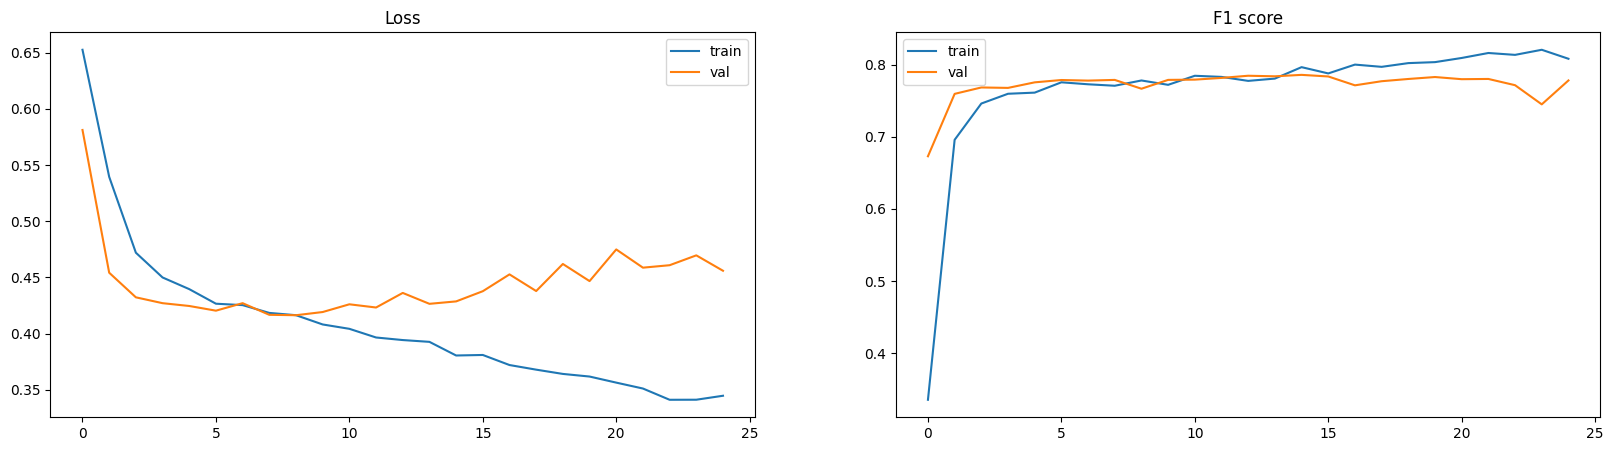

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].set_title('Loss')
axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='val')
axs[0].legend()

axs[1].set_title('F1 score')
axs[1].plot(history.history['f1_m'], label='train')
axs[1].plot(history.history['val_f1_m'], label='val')
axs[1].legend()

Generate the predictions.

In [19]:
y_pred=( model.predict([ X_test, Xloc_test_one_hot]) > 0.5 ).astype(int)
submission = pd.read_csv( 'data/test.csv' )[['id']]
submission['target'] = y_pred
print(submission.head(10))
submission.to_csv('submission_RNN_earlystop.csv',index=False)

102/102 [==============================] - 3s 23ms/step
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
5  12       1
6  21       0
7  22       0
8  27       0
9  29       0
